# Result Evaluation & Merge

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
import merge
import load

In [127]:
class_predictions = merge.merged_predictions()
test_predictions = merge.merged_predictions(test=True, keep_columns=['returnQuantity'])

## Team performance on test data

### Test data
To be able to compare team performances we agreed on a common test set. We generated it by splitting the original training data into 70% training and 30% test rows. Together with the actual submission, each team handed in their prediction for test set. This chapter evaluates these predictions.

### Mean accuracy

In [140]:
mean_accuracies = merge.mean_accuracies(test_predictions)

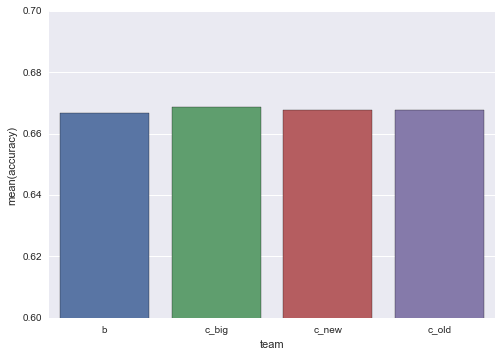

In [141]:
mean_accuracies_df = pd.DataFrame(mean_accuracies, columns=['accuracy'])
mean_accuracies_df.index.name = 'team'
mean_accuracies_df = mean_accuracies_df.reset_index()
ax = sns.barplot(x=mean_accuracies_df['team'], y=mean_accuracies_df['accuracy'])
lim = ax.set_ylim([0.6, 0.7])

All teams showed similar accuracies around **67%** on the test set.

### Split performance
All teams realisied that their classifiers performance depends highly on the amount of historical knowledge, e.g., the number of products returned by a customer. This realisation led us to divide classification into *splits* of known and unknown values. The figure below shows the size of each split and the accuracy of each team.

In [4]:
splits = merge.evaluate_split_performance()

### Split sizes

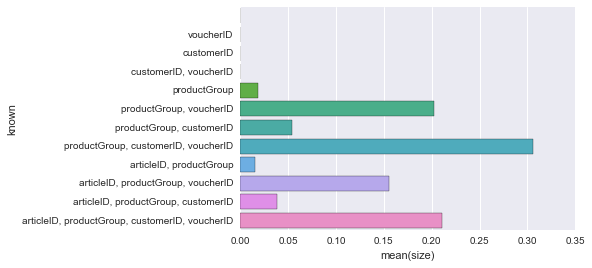

In [151]:
ax = sns.barplot(x='size', y=splits.index, data=splits)

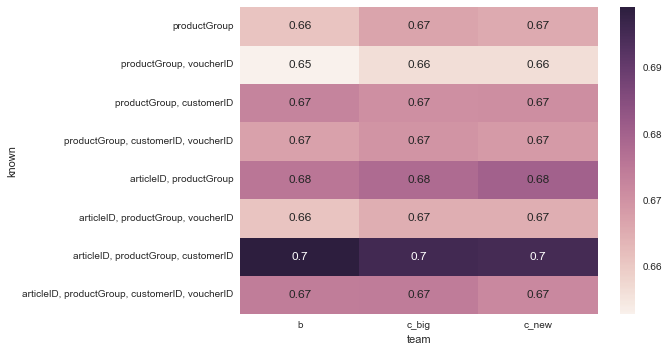

In [99]:
teams = load.team_names()
split_accuracies = splits.ix[4:,['b', 'c_big', 'c_new']]
split_accuracies.columns.name = 'team'
min_acc = split_accuracies.min().min()
max_acc = split_accuracies.max().max()
ax = sns.heatmap(split_accuracies, vmin=min_acc, vmax=max_acc, annot=True)

### Split sizes

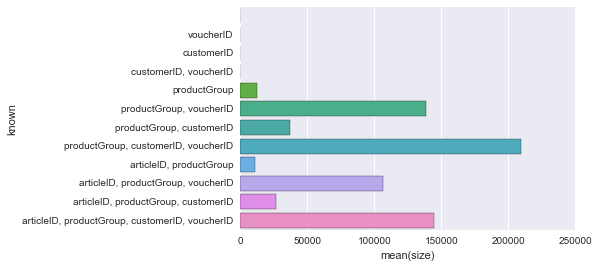

In [137]:
ax = sns.barplot(x='size', y=splits.index, data=splits)

The known splits *nothing known*, *only voucherID*, *only customerID* and *customerID and voucherID* do appear in the target data, but not this test set. They are removed from this figre. 

Again, the submissions show similar performance.

### Prediction differences
The predictions differ and the question is to what extent. The figure below shows the percentage of rows that have different classifications.

In [7]:
differences = merge.distinct_predictions()

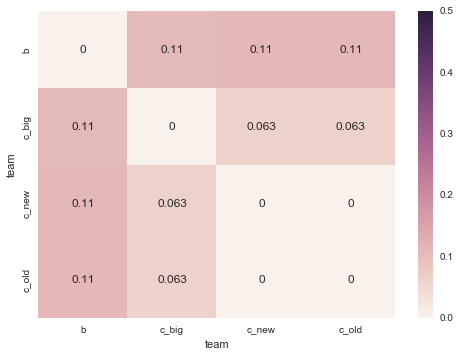

In [9]:
ax = sns.heatmap(differences.ix[:3, :3], vmin=0, vmax=0.5, annot=True)

The classifications provided by team C are similiar to each other. *c_big* was generated using a greater sampling of the training data, than *c_new*. This lead to a 6% difference and classification.

The classifications between team C and B differ in 11% of the rows.

### Prediction differences by split
The differences can be explored in greater detail by looking at the splits. The figure below shows the differnces.

In [12]:
split_differences = merge.distinct_split_predictions()

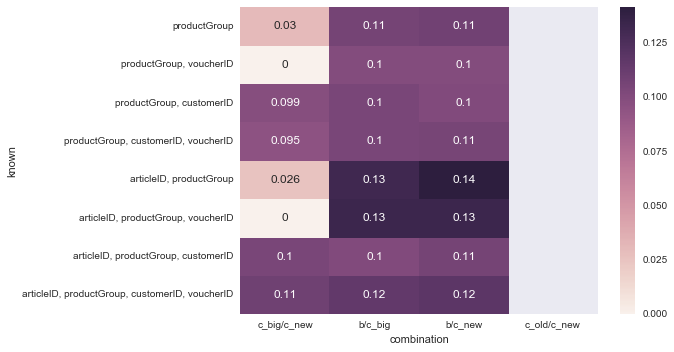

In [11]:
ax = sns.heatmap(split_differences.ix[4:, ['c_big/c_new', 'b/c_big', 'b/c_new', 'c_old/c_new']], annot=True)

Alas, the disagreements are not in few splits but evenly distributed.

## Team performance on target data

### Prediction differences

In [101]:
result_differences = merge.distinct_predictions(test=False)

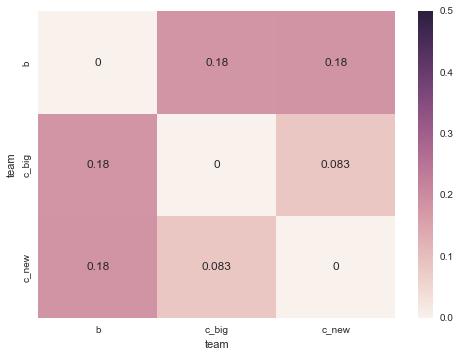

In [102]:
ax = sns.heatmap(result_differences.ix[:3, :3], vmin=0, vmax=0.5, annot=True)

### Split sizes in target data

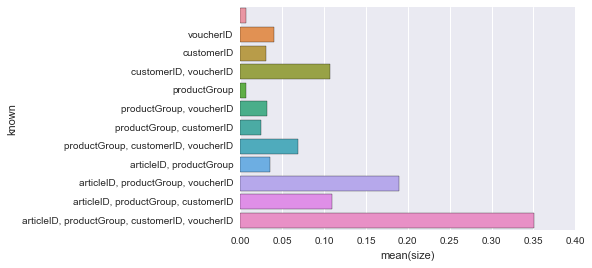

In [146]:
original_split_sizes = merge.original_split_sizes()
ax = sns.barplot(x='size', y=splits.index, data=original_split_sizes)

### Prediction differences by split

In [114]:
result_split_differences = merge.distinct_split_predictions(test=False)

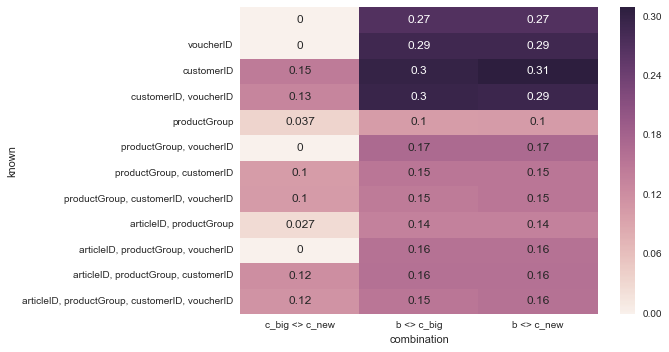

In [115]:
ax = sns.heatmap(result_split_differences.ix[:, ['c_big <> c_new', 'b <> c_big', 'b <> c_new']], annot=True)